In [1]:
# =========================
# XGB_Prototype_Modular.ipynb (Cell 1)
# Modularized version using refactored components
# =========================
from __future__ import annotations

import gc, os, sys, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping, EvaluationMonitor

import shap
import optuna
from packaging import version

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)

# ---- project config ----
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config as config

# ---- Import modularized components ----
from src.data.tabular_dataset import build_leak_proof_dataset
from src.data.storage import DataStorage
from src.backtest.splits import purged_time_splits, get_last_split
from src.backtest.engine import run_backtest


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---- paths ----
DATASET_PATH = str(config.PROCESSED_DATA_PATH)
OUTPUT_PLOT = str(config.XGB_CONFUSION_MATRIX_PLOT)
OUTPUT_PREDICTIONS = str(config.PREDICTIONS_CSV)
OUTPUT_SHAP = str(config.OUTPUTS_DIR / "shap_feature_importance.csv")


In [3]:
# =========================
# MODULAR DATA LOADING (Cell 3)
# Uses DataStorage + build_leak_proof_dataset for consistent loading
# This limits to first 1 million rows as requested
# =========================

print(f"[modular] Loading data from {DATASET_PATH}")

# Use DataStorage (DuckDB) to read Parquet/CSV efficiently
storage = DataStorage(processed_path=DATASET_PATH)
df_raw = storage.load_full_table()

# Use the modularized build_leak_proof_dataset function
df, y_dir, y_enc, feature_cols = build_leak_proof_dataset(
    df_raw,
    label_params={
        'up_tau': 0.25,
        'dn_tau_base': 0.08,
        'use_vol_scaled_dn': False,
    },
    downcast_float64=True,
    require_tradable=True,
    verbose=True
)

# Store labels in df for compatibility
y = y_enc
print(f"[modular] Dataset ready: {len(df):,} rows, {len(feature_cols)} features")


[modular] Loading data from C:\Users\reyno\Documents\GitHub\Project-BLD\data\processed\improved_normalized_labeled.parquet
[dataset] Rows: 27,405,019 | Class counts (−1,0,1): {-1:3412420, 0:19793980, 1:4198619}
[dataset] Features: 99 | Excluded 12 passthrough/leak columns
[dataset] Post-filter class counts: {-1:3179040, 0:18494207, 1:3887941}
[modular] Dataset ready: 25,561,188 rows, 99 features


In [4]:
# =========================
# Split using modularized splits module (Cell 4)
# =========================
print("[modular] Creating train/val split using purged_time_splits...")

# Use the modularized splitting function
train_idx, val_idx = get_last_split(df, n_splits=5, embargo=0)

# Extract features for training
X = df[feature_cols].copy()
X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_tr, y_val = y[train_idx], y[val_idx]

# Compute class weights
tr_counts = np.bincount(y_tr, minlength=3)
tr_counts = np.maximum(tr_counts, 1)
w_per_class = tr_counts.sum() / (3.0 * tr_counts)
w_tr = w_per_class[y_tr].astype("float32")

print(f"[modular] Train: {len(X_tr):,} | Val: {len(X_val):,}")
print(f"[modular] Class weights: {{-1:{float(w_per_class[0]):.4f}, "
      f"0:{float(w_per_class[1]):.4f}, 1:{float(w_per_class[2]):.4f}}}")


[modular] Creating train/val split using purged_time_splits...
[modular] Train: 21,300,990 | Val: 4,260,198
[modular] Class weights: {-1:2.6213, 0:0.4699, 1:2.0383}


In [5]:
# =========================
# Leak check (Cell 5)
# =========================
print("[modular] Running leak check...")
sus = [c for c in df.columns if c.startswith("target_")]
print(f"[sanity] target-like columns present: {sus[:8]}{'...' if len(sus)>8 else ''}")

# Inverse mapping for directional labels
_inv = np.array([-1, 0, 1])


[modular] Running leak check...
[sanity] target-like columns present: ['target_min_abs', 'target_max_abs', 'target_min_rel', 'target_max_rel', 'target_q_up_abs', 'target_q_dn_abs', 'target_q_up_rel', 'target_q_dn_rel']


In [7]:
# =========================
# Training utilities (Cell 6)
# =========================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

USE_GPU = True
USE_OPTUNA = False
N_TRIALS = 10
LOAD_EXISTING_MODEL = False
SAVE_MODEL_AFTER_TRAIN = True
OVERWRITE_SAVED_PARAMS = True

MODEL_DIR = Path(str(config.OUTPUTS_DIR)) / "xgb"
PARAMS_PATH = MODEL_DIR / "xgb_best_params.json"
MODEL_PATH = MODEL_DIR / "xgb_model.ubj"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

import json

def _save_json(obj, p: Path):
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def _load_json(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def _np_view(df):
    return df.to_numpy(dtype=np.float32, copy=False)

def _merge_common(best: dict, use_gpu: bool) -> dict:
    common = {
        "tree_method": "hist",
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "random_state": RANDOM_SEED,
        "n_jobs": max(1, os.cpu_count()-1),
        "early_stopping_rounds": 100,
        "device": ("cuda" if use_gpu else "cpu"),
    }
    merged = {**common, **best}
    return merged


In [9]:
# =========================
# Opportunity coverage helper (Cell 7)
# =========================
from numpy.lib.stride_tricks import sliding_window_view

def _forward_extrema(df_item, horizon):
    """Compute forward max/min returns for a single item's time series."""
    x = df_item['mid_price'].to_numpy()
    if len(x) < horizon:
        out = df_item[['timestamp','item','mid_price']].copy()
        out['fwd_up_ret'] = np.nan
        out['fwd_dn_ret'] = np.nan
        return out
    win = sliding_window_view(x, horizon)
    fwd_max = np.concatenate([win.max(1), np.full(horizon-1, np.nan)])
    fwd_min = np.concatenate([win.min(1), np.full(horizon-1, np.nan)])
    out = df_item[['timestamp','item','mid_price']].copy()
    out['fwd_up_ret'] = (fwd_max - x) / x
    out['fwd_dn_ret'] = (x - fwd_min) / x
    return out

def opportunity_coverage(prices, preds, horizon=60, up_tau=0.03, dn_tau=0.03, score_col='score'):
    """
    Compute opportunity coverage metrics.

    Measures how well the model captures good trading opportunities
    within the specified horizon.
    """
    preds = preds.copy()
    if score_col not in preds:
        preds['score'] = preds['Pp1'] - preds['Pm1']
    prices = prices.sort_values(['item','timestamp']).copy()
    opp = (prices.groupby('item', group_keys=False)
                 .apply(lambda g: _forward_extrema(g, horizon)))

    joined = preds.merge(opp, on=['item','timestamp'], how='inner')
    joined['good_up']  = joined['fwd_up_ret'] >= up_tau
    joined['good_dn']  = joined['fwd_dn_ret'] >= dn_tau
    joined['flag_buy'] = joined['score'] > 0
    joined['flag_sell']= joined['score'] < 0

    metrics = {
        'recall@good_up': (joined['flag_buy'] & joined['good_up']).sum() / max(1, joined['good_up'].sum()),
        'precision@buy':  (joined['flag_buy'] & (joined['fwd_up_ret']>0)).sum() / max(1, joined['flag_buy'].sum()),
        'recall@good_dn': (joined['flag_sell'] & joined['good_dn']).sum() / max(1, joined['good_dn'].sum()),
        'precision@sell': (joined['flag_sell'] & (joined['fwd_dn_ret']>0)).sum() / max(1, joined['flag_sell'].sum()),
        'coverage%':      100 * joined.groupby('timestamp')['flag_buy'].max().mean()
    }
    return pd.Series(metrics), joined


In [10]:
# =========================
# Training function (Cell 8)
# =========================
def train_classifier(
    X_tr, y_tr, X_val, y_val,
    w_tr=None,
    n_trials=10,
    use_gpu=USE_GPU,
    use_optuna=USE_OPTUNA,
    params_path=PARAMS_PATH,
    model_path=MODEL_PATH,
    load_existing_model=LOAD_EXISTING_MODEL,
    save_model_after_train=SAVE_MODEL_AFTER_TRAIN,
    overwrite_saved_params=OVERWRITE_SAVED_PARAMS,
):
    """
    Train XGBoost classifier with optional HPO.
    """

    # Fast path: load existing model
    if load_existing_model and Path(model_path).exists():
        print(f"[train] Loading existing model → {model_path}")
        clf = xgb.XGBClassifier()
        clf.load_model(str(model_path))
        if not hasattr(clf, "classes_") or getattr(clf, "classes_", None) is None:
            clf.classes_ = np.array([0,1,2], dtype=np.int64)
            clf.n_classes_ = 3
        if Path(params_path).exists():
            params = _load_json(params_path)
        else:
            params = {"framework": "xgb", "loaded_from_model": True}
        return clf, params

    # Load saved params if not using Optuna
    loaded_params = None
    if not use_optuna and Path(params_path).exists():
        loaded_params = _load_json(params_path)
        print(f"[train] Optuna disabled — loaded saved params from {params_path}")

    # Prepare NumPy views once
    X_tr_np  = _np_view(X_tr)
    X_val_np = _np_view(X_val)

    # Precompute validation metadata once (used by opportunity_coverage)
    # NOTE: df and val_idx are taken from outer scope (your notebook)
    val_meta = df.loc[val_idx, ['timestamp','item','mid_price']].reset_index(drop=True)
    prices_val = df.loc[val_idx, ['timestamp','item','mid_price']]

    # ===== HPO path =====
    if use_optuna and loaded_params is None:
        print(f"[train] Running Optuna for {n_trials} trials...")
        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
        )

        def objective(trial):
            params = {
                "n_estimators":       trial.suggest_int("n_estimators", 600, 1600),
                "max_depth":          trial.suggest_int("max_depth", 10, 18),
                "learning_rate":      trial.suggest_float("learning_rate", 0.06, 0.20, log=True),
                "subsample":          trial.suggest_float("subsample", 0.7, 1.0),
                "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.7, 1.0),
                "min_child_weight":   trial.suggest_float("min_child_weight", 1.0, 12.0),
                "reg_lambda":         trial.suggest_float("reg_lambda", 1e-3, 20.0, log=True),
                "reg_alpha":          trial.suggest_float("reg_alpha", 1e-3, 20.0, log=True),
                "gamma":              trial.suggest_float("gamma", 0.0, 5.0),
                "max_bin":            trial.suggest_int("max_bin", 128, 512),
                "grow_policy":        trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            }
            params = _merge_common(params, use_gpu)

            clf = xgb.XGBClassifier(**params)
            clf.fit(
                X_tr_np,
                y_tr,
                sample_weight=w_tr,
                eval_set=[(X_val_np, y_val)],
                verbose=False,
            )

            # ---- Validation predictions (GPU) ----
            # Using sklearn API here avoids extra DMatrix allocation every trial.
            best_it = getattr(clf, "best_iteration_", None)
            if best_it is not None:
                y_proba = clf.predict_proba(X_val_np, iteration_range=(0, int(best_it) + 1))
            else:
                y_proba = clf.predict_proba(X_val_np)
            y_proba = np.asarray(y_proba)
            yhat = y_proba.argmax(axis=1)

            # F1 metric
            f1 = f1_score(y_val, yhat, average="macro")

            # Profit-aware proxy (CPU-heavy part)
            try:
                classes_enc = np.asarray(getattr(clf, "classes_", np.array([0,1,2])))
                classes_dec = _inv[classes_enc]
                buy_idx  = int(np.where(classes_dec == 1)[0][0]) if (classes_dec == 1).any() else (y_proba.shape[1]-1)
                sell_idx = int(np.where(classes_dec == -1)[0][0]) if (classes_dec == -1).any() else 0
                score = y_proba[:, buy_idx] - y_proba[:, sell_idx]

                preds = pd.DataFrame({
                    'timestamp': val_meta['timestamp'].values,
                    'item':      val_meta['item'].values,
                    'mid_price': val_meta['mid_price'].values,
                    'score':     score.astype('float32'),
                })

                metr, _ = opportunity_coverage(
                    prices=prices_val,  # already a slice, no extra copy
                    preds=preds[['timestamp','item','mid_price','score']],
                    horizon=60,
                    up_tau=0.03,
                    dn_tau=0.03,
                    score_col='score',
                )
                profit_proxy = float(
                    metr.get('precision@buy', 0.0) * metr.get('recall@good_up', 0.0)
                )
            except Exception:
                profit_proxy = 0.0

            combo = 0.6 * profit_proxy + 0.4 * f1

            trial.report(combo, step=int(best_it) if best_it is not None else 0)
            if trial.should_prune():
                raise optuna.TrialPruned()

            return combo

        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        best = study.best_params
        best = _merge_common(best, use_gpu)
        if overwrite_saved_params:
            _save_json(best, params_path)
            print(f"[train] Saved best params → {params_path}")

    # ===== Saved/baseline params path =====
    else:
        if loaded_params is not None:
            best = loaded_params
        else:
            print("[train] Optuna disabled and no params file found — using baseline params.")
            best = {
                "n_estimators": 1050,
                "max_depth": 17,
                "learning_rate": 0.076,
                "subsample": 0.854,
                "colsample_bytree": 0.877,
                "min_child_weight": 1.51,
                "reg_lambda": .41,
                "reg_alpha": 0.0054,
                "gamma": 0.325,
                "max_bin": 493,
                "grow_policy": "depthwise",
            }
        best = _merge_common(best, use_gpu)

    # ===== Final train with chosen params =====
    clf = xgb.XGBClassifier(**best)
    clf.fit(
        X_tr_np,
        y_tr,
        sample_weight=w_tr,
        eval_set=[(X_val_np, y_val)],
        verbose=False,
    )

    if save_model_after_train:
        try:
            clf.save_model(str(model_path))
            print(f"[train] Saved model → {model_path}")
        except Exception as e:
            print(f"[train][warn] Could not save model: {e}")
    try:
        _save_json(best, params_path)
    except Exception as e:
        print(f"[train][warn] Could not save params: {e}")

    return clf, {"framework": "xgb", **best}


# ---- Run training ----
print("[modular] Training classifier...")
clf, params = train_classifier(
    X_tr, y_tr, X_val, y_val,
    w_tr=w_tr,
    n_trials=N_TRIALS,
    use_gpu=USE_GPU,
    use_optuna=USE_OPTUNA,
)
print("[modular] Classifier params:", params)
gc.collect()


[modular] Training classifier...
[train] Optuna disabled — loaded saved params from C:\Users\reyno\Documents\GitHub\Project-BLD\outputs\xgb\xgb_best_params.json
[train] Saved model → C:\Users\reyno\Documents\GitHub\Project-BLD\outputs\xgb\xgb_model.ubj
[modular] Classifier params: {'framework': 'xgb', 'tree_method': 'hist', 'objective': 'multi:softprob', 'num_class': 3, 'eval_metric': 'mlogloss', 'random_state': 42, 'n_jobs': 31, 'early_stopping_rounds': 100, 'device': 'cuda', 'n_estimators': 1056, 'max_depth': 17, 'learning_rate': 0.07630560271534147, 'subsample': 0.8542703315240835, 'colsample_bytree': 0.8777243706586128, 'min_child_weight': 1.5109545399199749, 'reg_lambda': 0.4102689328356389, 'reg_alpha': 0.00541289211202473, 'gamma': 0.3252579649263976, 'max_bin': 493, 'grow_policy': 'depthwise'}


2837

In [ ]:
# =========================
# Calibration (Cell 9)
# =========================
from sklearn.calibration import CalibratedClassifierCV

xgb_params = {k: v for k, v in params.items() if k != "framework"}

base = XGBClassifier(**xgb_params)
base.fit(X_tr, y_tr, sample_weight=w_tr, eval_set=[(X_val, y_val)], verbose=False)

pred_base = base.predict(X_val)
f1_base = f1_score(y_val, pred_base, average="macro")
print(f"[cal] Base macro-F1 (no calibration): {f1_base:.4f}")

DO_CALIBRATE = True
if DO_CALIBRATE:
    clf = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
    clf.fit(X_val, y_val)
    pred_cal = clf.predict(X_val)
    f1_cal = f1_score(y_val, pred_cal, average="macro")
    print(f"[cal] Calibrated macro-F1: {f1_cal:.4f}")
else:
    clf = base


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:23:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[cal] Base macro-F1 (no calibration): 0.5480


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[cal] Calibrated macro-F1: 0.4980


In [ ]:
# =========================
# Build predictions DataFrame (Cell 10)
# =========================
DATA_DF = df
META_COLS = ['timestamp','item','mid_price']

IDX = df.index[val_idx]
test_meta = df.loc[IDX, META_COLS].reset_index(drop=True).copy()
test_meta['vol_est'] = (df.loc[IDX, 'vol_est'].values
                        if 'vol_est' in df.columns else 1.0)

proba_val = getattr(clf, "predict_proba", lambda X: None)(X_val)

classes_enc = np.asarray(getattr(clf, "classes_", np.array([0,1,2])))
classes_dec = _inv[classes_enc]

proba_df = pd.DataFrame(proba_val, columns=[f'P{c}' for c in classes_dec])

rename = {}
for c in classes_dec:
    if c == -1: rename[f'P{c}'] = 'Pm1'
    elif c == 0: rename[f'P{c}'] = 'P0'
    elif c == 1: rename[f'P{c}'] = 'Pp1'
proba_df = proba_df.rename(columns=rename)
for col in ['Pm1','P0','Pp1']:
    if col not in proba_df.columns:
        proba_df[col] = 0.0

preds_test = pd.concat([test_meta, proba_df], axis=1).reset_index(drop=True)

assert isinstance(preds_test, pd.DataFrame)
assert {'timestamp','item','mid_price','Pm1','P0','Pp1'}.issubset(preds_test.columns)


In [ ]:
# =========================
# Synthesize scores (Cell 11)
# =========================
def _get_first(df, names, default=np.nan):
    for n in names:
        if n in df.columns:
            return df[n].astype(float)
    return np.full(len(df), default, dtype=float)

p_pos = _get_first(preds_test, ['Pp1','P1','P(1)','prob_1','proba_1'], default=np.nan)
p_neg = _get_first(preds_test, ['Pm1','P-1','P(-1)','prob_-1','proba_-1'], default=np.nan)
p_neu = _get_first(preds_test, ['P0','P(0)','prob_0','proba_0'], default=np.nan)

has_real_sell = np.isfinite(p_neg).any() and (np.nanmax(p_neg) > 0)

if has_real_sell:
    preds_test['score_buy']  = p_pos - p_neg
    preds_test['score_sell'] = p_neg - p_pos
else:
    preds_test['score_buy']  = p_pos - (p_neu if np.isfinite(p_neu).any() else 0.0)
    preds_test['score_sell'] = np.nan

if 'score' not in preds_test.columns:
    preds_test['score'] = preds_test['score_buy']

print("Added score columns:", [c for c in ['score_buy','score_sell','score'] if c in preds_test.columns])


Added score columns: ['score_buy', 'score_sell', 'score']


In [ ]:
# =========================
# Opportunity coverage metrics (Cell 12)
# =========================
HORIZON = 60
UP_TAU  = 0.03
DN_TAU  = 0.03

prices_test = df.loc[val_idx, ['timestamp','item','mid_price']].copy()
opp_metrics, opp_joined = opportunity_coverage(prices_test, preds_test,
                                               horizon=HORIZON, up_tau=UP_TAU, dn_tau=DN_TAU)
print("[modular] Opportunity coverage metrics:")
print(opp_metrics)


C:\Users\reyno\AppData\Local\Temp\ipykernel_30172\3340249347.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _forward_extrema(g, horizon)))


[modular] Opportunity coverage metrics:
recall@good_up     0.649955
precision@buy      0.686705
recall@good_dn     0.577205
precision@sell     0.754159
coverage%         99.717354
dtype: float64


[modular] F1 (macro): 0.5480
[modular] F1 (weighted): 0.7619
              precision    recall  f1-score   support

          -1     0.4449    0.3734    0.4061    470315
           0     0.8820    0.8332    0.8569   3385403
           1     0.3059    0.5045    0.3809    404480

    accuracy                         0.7513   4260198
   macro avg     0.5443    0.5704    0.5480   4260198
weighted avg     0.7790    0.7513    0.7619   4260198



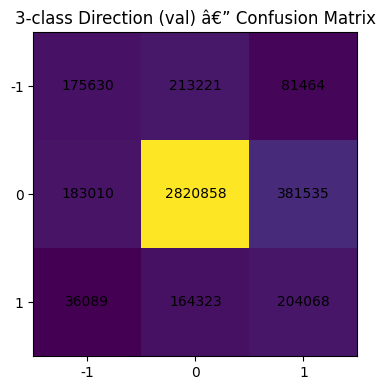

In [ ]:
# =========================
# Validation metrics & confusion matrix (Cell 13)
# =========================
y_val_hat = clf.predict(X_val)
proba_val = getattr(clf, "predict_proba", lambda X: None)(X_val)

macro_f1 = f1_score(y_val, y_val_hat, average="macro")
weighted_f1 = f1_score(y_val, y_val_hat, average="weighted")
print(f"[modular] F1 (macro): {macro_f1:.4f}")
print(f"[modular] F1 (weighted): {weighted_f1:.4f}")
print(classification_report(y_val, y_val_hat, target_names=["-1","0","1"], digits=4))

cm = confusion_matrix(y_val, y_val_hat, labels=[0,1,2])
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("3-class Direction (val) â€” Confusion Matrix")
ax.set_xticks([0,1,2]); ax.set_xticklabels(["-1","0","1"])
ax.set_yticks([0,1,2]); ax.set_yticklabels(["-1","0","1"])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
fig.savefig(OUTPUT_PLOT, dpi=160)
plt.show()


In [ ]:
# =========================
# Build predictions for backtesting (Cell 14)
# =========================
y_val_hat = clf.predict(X_val)
proba_val = getattr(clf, "predict_proba", lambda X: None)(X_val)

classes_enc = np.asarray(getattr(clf, "classes_", np.array([0,1,2])))
classes_dec = _inv[classes_enc]

pred_dir_val = _inv[y_val_hat]

pred_df = pd.DataFrame({
    "timestamp": df.loc[val_idx, "timestamp"].values,
    "item": df.loc[val_idx, "item"].values if "item" in df.columns else "",
    "mid_price": df.loc[val_idx, "mid_price"].values if "mid_price" in df.columns else np.nan,
    "true_dir": _inv[y_val],
    "pred_dir": pred_dir_val,
})

pred_df["tradable"] = (df.loc[val_idx, "tradable"].values.astype("int8")
                       if "tradable" in df.columns else 1)

if proba_val is not None:
    for k, lab in enumerate(classes_dec):
        pred_df[f"proba_{lab}"] = proba_val[:, k].astype("float32")

pred_df["pred_label"] = pred_dir_val.astype("int8")
if proba_val is not None:
    buy_idx = int(np.where(classes_dec == 1)[0][0])
    pred_df["pred_proba_buy"] = proba_val[:, buy_idx].astype("float32")
else:
    pred_df["pred_proba_buy"] = (pred_df["pred_dir"] == 1).astype("float32")

pred_df.to_csv(OUTPUT_PREDICTIONS, index=False)
print(f"[modular] Saved predictions â†’ {OUTPUT_PREDICTIONS}")


[modular] Saved predictions â†’ C:\Users\reyno\Documents\GitHub\Project-BLD\outputs\xgb_predictions.csv


In [ ]:
# =========================
# Backtest tuning + best backtest (Cell 15 alt)
# =========================
from pathlib import Path
from src.backtest.engine import tune_backtest_knobs

print("[modular] Tuning backtest knobs with src.backtest.engine...")

TRADE_LOG_PATH = Path(config.XGB_TRADE_LOG_CSV)
PLOTS_DIR = Path(config.XGB_TRADING_DIR)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TRADE_LOG_PATH.parent.mkdir(parents=True, exist_ok=True)

# Run tuning on the same predictions CSV you already generate
study, best_summary, best_trades, best_eq = tune_backtest_knobs(
    pred_path=Path(OUTPUT_PREDICTIONS),   # uses the CSV you created earlier
    study_name="bt_knobs_v20",
    storage_dir="backtests/db",
    total_trials=200,                     # adjust as needed
    trade_log_path=TRADE_LOG_PATH,       # also saves best trades to CSV
    initial_capital=1_000_000_000.0,
    max_trades_per_minute=2,
    spread_bps=10.0,
    fee_bps=100.0,
    slippage_bps=0.0,
    median_window=30,
    impact_cap_bps=200.0,
    max_positions_per_item=1,
    cooldown_minutes=0,
    bar_seconds=60,
)

# Make results visible to the diagnostics cell
trades = best_trades
equity = best_eq
summary = best_summary

print("[modular] Best backtest summary:")
for k, v in best_summary.items():
    print(f"  {k}: {v}")

print(f"[modular] Best trades saved to: {TRADE_LOG_PATH}")
print(f"[modular] Optuna best params: {study.best_params}")


[modular] Tuning backtest knobs with src.backtest.engine...


[I 2025-11-19 16:14:04,491] A new study created in RDB with name: bt_knobs_v19


[optuna] completed trials: 200
Best params: {'min_trade_amount': 43884673.97468845, 'min_confidence': 0.9319720261942077, 'exit_profit_threshold': 0.3864550992743331, 'stop_loss_threshold': 0.020089557364031098, 'persist_bars': 27, 'alpha': 9.454379110802929, 'min_confidence_streak': 0.7266526196524977}
Best value: 15.445097521971016
Summary: {'Final Capital': '2,849,292,332', 'Total Profit': '1,849,292,332', 'Num Trades': 120, 'Win Rate': '45.00%', 'Average Return / Trade': '15.66%', 'Average Win': '37.23%', 'Average Loss': '-1.99%', 'Gross Profit': '2,012,132,491', 'Gross Loss': '-162,840,159', 'Profit Factor': '12.36', 'Average Duration (min)': '330.17'}
[modular] Best backtest summary:
  Final Capital: 2,849,292,332
  Total Profit: 1,849,292,332
  Num Trades: 120
  Win Rate: 45.00%
  Average Return / Trade: 15.66%
  Average Win: 37.23%
  Average Loss: -1.99%
  Gross Profit: 2,012,132,491
  Gross Loss: -162,840,159
  Profit Factor: 12.36
  Average Duration (min): 330.17


In [ ]:
# =========================
# Diagnostic plots (Cell 16)
# =========================
from sklearn.metrics import precision_recall_curve, auc

def _save_fig(fig, name: str, dpi=160):
    path = os.path.join(PLOTS_DIR, name)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    return path

print(f"[modular] Saving plots to: {PLOTS_DIR}")

# Equity curve
if len(equity):
    fig = plt.figure(figsize=(9,3))
    ax = plt.gca()
    ax.plot(equity["timestamp"].values, equity["equity"].values)
    ax.set_title("Equity Over Time (Modular)")
    ax.set_xlabel("timestamp")
    ax.set_ylabel("equity")
    _save_fig(fig, "equity_curve_modular.png")

    # Invested % curve
    if "invested_pct" in equity.columns:
        fig = plt.figure(figsize=(9,3))
        ax = plt.gca()
        ax.plot(equity["timestamp"].values, 100*equity["invested_pct"].values)
        ax.set_title("Invested % of Equity Over Time (Modular)")
        ax.set_xlabel("timestamp"); ax.set_ylabel("invested %")
        _save_fig(fig, "invested_curve_modular.png")

    # Drawdown curve
    e = equity["equity"].astype(float).to_numpy()
    peaks = np.maximum.accumulate(e)
    dd = (e - peaks) / np.maximum(peaks, 1e-12)
    fig = plt.figure(figsize=(9,2.5))
    ax = plt.gca()
    ax.plot(equity["timestamp"].values, 100*dd)
    ax.set_title(f"Drawdown (%) â€” Min: {100*dd.min():.2f}%")
    ax.set_xlabel("timestamp"); ax.set_ylabel("drawdown %")
    _save_fig(fig, "drawdown_curve_modular.png")

# Trade diagnostics
if len(trades):
    # PnL histogram
    fig = plt.figure(figsize=(7,3))
    ax = plt.gca()
    ax.hist(trades["pnl"].astype(float).values, bins=80)
    ax.set_title("Trade PnL Histogram (Modular)")
    ax.set_xlabel("PnL"); ax.set_ylabel("count")
    _save_fig(fig, "trades_pnl_hist_modular.png")

    # Duration vs return scatter
    if {"duration_min","return"}.issubset(trades.columns):
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        x = trades["duration_min"].astype(float).values
        y = trades["return"].astype(float).values
        ax.scatter(x, y, s=8, alpha=0.5)
        ax.set_title("Trade Return vs Duration (Modular)")
        ax.set_xlabel("duration (min)"); ax.set_ylabel("return")
        _save_fig(fig, "trades_return_vs_duration_modular.png")

# Feature importance
try:
    booster = getattr(clf, "get_booster", lambda: None)()
    if booster is not None:
        try:
            score = booster.get_score(importance_type='gain')
        except Exception:
            score = booster.get_score(importance_type='weight')
        if score:
            imp = pd.DataFrame({"feature": list(score.keys()),
                                "importance": list(score.values())}).sort_values("importance", ascending=False).head(25)
            fig = plt.figure(figsize=(8,5))
            ax = plt.gca()
            ax.barh(imp["feature"].values[::-1], imp["importance"].values[::-1])
            ax.set_title("Top 25 Features (XGBoost importance)")
            ax.set_xlabel("importance"); ax.set_ylabel("feature")
            _save_fig(fig, "xgb_feature_importance_top25_modular.png")
except Exception as e:
    print(f"[modular] Feature importance plot skipped: {e}")

print("[modular] Done.")


[modular] Saving plots to: C:\Users\reyno\Documents\GitHub\Project-BLD\outputs\trading\XGB_trading


NameError: name 'equity' is not defined